# Heat Maps, Interpolation, and Colour Map Choice

Heat maps are another way of plotting spike train data. An example is below:

![](images/heat_map.png)

Like a PSTH, the heat map has time on the *x* axis, and plots the probability of spikes at each time point. However, the heat maps a more condensed, information-rich, and efficient version of the PSTHs: rather than needing 10 plots to show the histograms for all 10 levels of intensity, we do so in a single plot. Heat maps essentially allow us to plot 3 dimensions rather than only two; we have the *x* and *y* axes, but then we can plot a third variable (dimension) using colour (or intensity of colour). Think of it the above plot rotated in a plane, so that if before, you were looking at the plot from the side, now you're looking at it from above. More intense colours indicate a higher spike probability at that time point. 

We can use Matplotlib's [`ax.imshow()`](https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.axes.Axes.imshow.html) function to generate a heat map. This function allows us to plot any 2-dimensional dataset (like a 2D array) as an image, and apply colour to the values in the array. To demonstrate, first we'll load the necessary packages, and the `ten_intensites` data:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

with open('ten_intensities.pkl', 'rb') as handle:
    ten_intensities = pickle.load(handle, encoding='latin1')

Recall that the `ten_intensities` data is stored as a dictionary of lists, with one dictionary entry for each intensity level. The value of each dictionary entry is a list, which in turn contains a list of spike times for each trial. 

Since heat maps are histograms, and `ax.imshow()` is designed to plot 2D arrays, we'll need to convert the data to histograms and arrange it as a 2D array.

First, we combine all the data from the `ten_intensities` data set into a dictionary whose keys are the intensity levels, and values are the histograms (spike probabilities). We generate the histograms the same way we did in the previous chapter when working with the `ten_intensities` data. 

In [2]:
# Set some experimental parameters
num_intensities = len(ten_intensities)
num_trials = 10 
len_trials = 20

# Create empty dict to which we will add entries below
psth_dict = {}

# Loop through each stimulus intensity
for key in ten_intensities.keys():
    # Use nested list comprehension to put spike times from all
    # trials into one list
    spike_times = [a for b in ten_intensities[key] for a in b] 
    
    # Compute the histogram of spike times over 20 ms trials
    spike_count, bins = np.histogram(spike_times, bins=range(len_trials))
    
    # Add the histogram for this intensity to the dictionary of PSTHs
    psth_dict[float(key[0])] = spike_count / num_trials

Now we plot the heat map, by looping through each entry (intensity level) in the `psth_hist` dictionary. We do this using list comprehension *inside* the plot command — i.e., as the data that we give plt.imshow() as input. Each intensity level is used to draw a row of the heat map image. Note the use of the `sorted()` function inside the list comprehension; this is critical because dictionaries are not inherently stored in any order. They are organized by keys, and in this case the first character of the key name is the intensity level (`1_intensity`, `2_intensity`, etc.). So by applying `sorted()` to the keys, they are plotted in numerical order. 

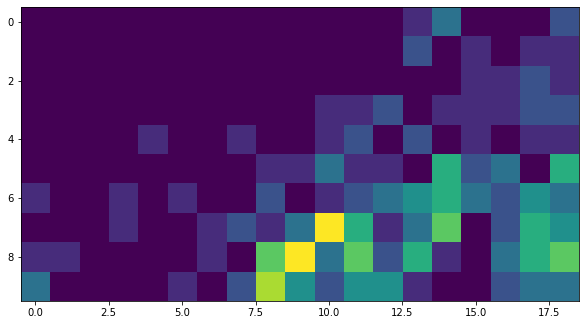

In [3]:
fig = plt.figure(figsize=[10,10])

plt.imshow([psth_dict[i] for i in sorted(psth_dict.keys())],
          )
plt.show()

The above plot is far less pretty than the one at the top of this section! We need to pass additional arguments to `plt.imshow()`, and then add some more generic Matplotlib tweaks in order to get it to look the way we want. 

Below, the arguments we add are:
- the `origin` argument puts 0 on the *y* axis at the bottom, rather than the top, which makes sense in this case. 
- the `cmap` argument sets the colour map to 'hot'. (For a list of Matplotlib colour maps, see [this page](https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html))
- the `interpolation` argument changes that mathematical formula is used to determine the colour values at each point in the plot. The default *antialiased* method produces a blocky-looking output above because it's computing the colour of each pixel in the plot based on the values in teh histogram, which are computed at 1 ms intervals. Using *bilinear* interpolation estimates the values on a finer time scale, making the plot appear more smooth and continuous.   

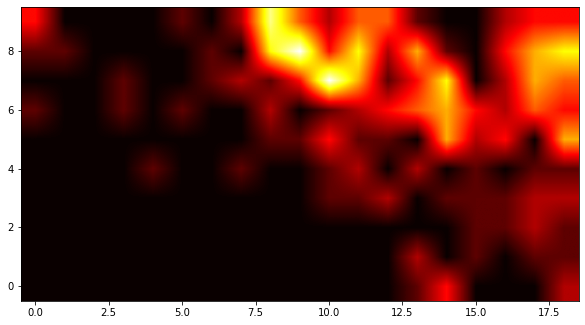

In [4]:
fig = plt.figure(figsize=[10,10])

plt.imshow([psth_dict[i] for i in sorted(psth_dict.keys())],
               origin='lower',
               cmap='hot', 
               interpolation='bilinear'
          )
plt.show()

Now we can add features that help with interpretation, such as axis labels and a leged explaining what the colours represent.

Note the change to `plt.imshow()` in that we assign the output of it to a variable, `aa`. This makes `aa` a *pointer* to the axis of the heat map, which allows us to attach things to it later, specifically the colour legend.

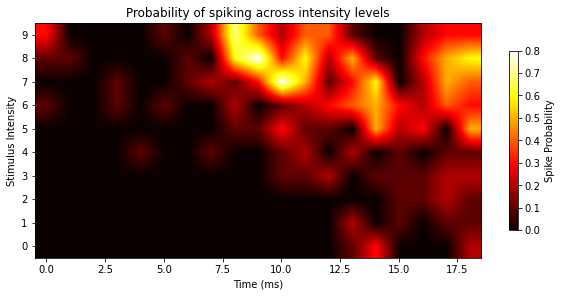

In [5]:
fig = plt.figure(figsize=[10,10])

aa = plt.imshow([psth_dict[i] for i in sorted(psth_dict.keys())],
                origin='lower',
                cmap='hot', 
                interpolation='bilinear')

# make pretty
# Set the y ticks based on the intensity levels
plt.yticks([x for x in range(num_intensities)], 
           [str(x) for x in range(num_intensities)])
plt.ylabel('Stimulus Intensity')
plt.xlabel('Time (ms)')
plt.title('Probability of spiking across intensity levels')

# Add a colourbar legend
cb = fig.colorbar(aa, shrink=0.33) 
cb.ax.set_ylabel('Spike Probability')

plt.show()

The heat map above makes a few interesting properties of the data immediately evident, more clearly and concisely than ten PSTHs or raster plots. For example, it's clear that spiking increases with stimulus intensity, particularly after 7.5 ms. Recall that the stimulus onset time was 5 ms, so there is a delay prior to spiking onset (the neuron's characteristic *latency to first spike*). As well, the heat map displays a documented property of neurons' responses to stimuli of varying intensity: as intensity increases, the latency to first spike becomes shorter (i.e., the neuron spikes sooner after a more intense stimulus). We can see this in the fact that the "hot spots" in the image occur later for lower-intensity stimuli.

### Interpolation

For better or for worse, a consequence of the bilinear interpolation is that it takes data that were measured at discrete levels of stimulus intensity, and interpolates between those levels to provide a smoothed representation of the data. In other words, it's making inferences about what the values would be in between the tested levels of stimulus intensity. 

This is not to imply that interpolation is invalid; indeed it's a valuable tool and interpolation methods are mathematical formulae that are reproducible and well-understood. But it's important to be aware of interpolation and consider what effects it might have in some situations. On the positive side, interpolation can reduce noise in the data by smoothing it. On the other hand, if there are big gaps in your data it may not be appropriate to interpolate, because interpolation makes certain assumptions about the shape (distribution) of your data - and the differences between interpolation methods amount to the differences in assumptions that are made.

Below are examples showing different interpolation methods. Bilinear and bicubic are smoothed forms of interpolation, where nearest-neighbor looks "blocky" because it's plotting the actual values with no interpolation, more consistent with the actual data. The Hanning method produces results that appear somewhat in between the others. 

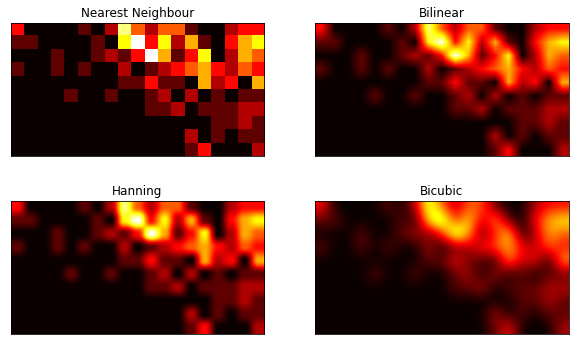

In [6]:
fig = plt.figure(figsize=[10,6])

ax = plt.subplot(221)
aa = ax.imshow([psth_dict[i] for i in sorted(psth_dict.keys())],
               origin='lower',
               cmap='hot',
               interpolation='nearest') 
plt.title('Nearest Neighbour')
plt.yticks([]); plt.xticks([])

ax = plt.subplot(222)
aa = ax.imshow([psth_dict[i] for i in sorted(psth_dict.keys())],
               origin='lower',
               cmap='hot', 
               interpolation='bilinear') 
plt.title('Bilinear')
plt.yticks([]); plt.xticks([])

ax = plt.subplot(223);
plt.title('Hanning')
aa = ax.imshow([psth_dict[i] for i in sorted(psth_dict.keys())],
               origin='lower',
               cmap='hot', 
               interpolation='hanning') 
plt.yticks([]); plt.xticks([])

ax = plt.subplot(224)
plt.title('Bicubic')
aa = ax.imshow([psth_dict[i] for i in sorted(psth_dict.keys())],
               origin='lower',
               cmap='hot', 
               interpolation='bicubic')
plt.yticks([]); plt.xticks([])

plt.show()

### Colour Map Choices

One final comment about the heat maps above: your choice of colour map (`cmap`) matters. One way to choose a colour map is based on one's individual intuitions about aesthetics. For example, I personally think the one used above (`hot`) is quite attractive. However, it's important to consider the neuroscience of how humans interpret colour. Even though the colour spectrum is continuous (wavelengths of electromagnetic radiation ranging from approximately 400–700 nm), we see it as distinct colours (classically, red, orange, yellow, green, blue, indigo, and violet). Although we can discriminate different hues within each of those colours, we nonetheless see colours categorically. In other words, two equally-different values at different parts of the colour range may not be perceived as the same magnitude of difference. For example in the bottom left (`cmap='jet'`) the green areas seem to 'pop' relative to the blue, and there is are patches of orange that really stand out. 

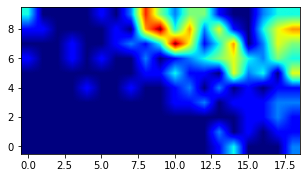

In [7]:
fig = plt.figure(figsize=[5,3])

plt.imshow([psth_dict[i] for i in sorted(psth_dict.keys())],
               origin='lower',
               cmap='jet', 
               interpolation='bilinear')
plt.show()

On the other hand, if we use a monochromatic (single-colour) map, the differences in numerical values are represented in a more continuous fashion, as the intensity (brightness) of the pixel, resulting in smoother, more continuous-looking gradients:

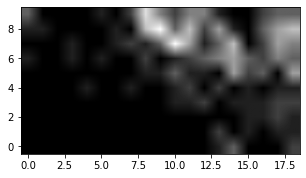

In [8]:
fig = plt.figure(figsize=[5,3])

plt.imshow([psth_dict[i] for i in sorted(psth_dict.keys())],
               origin='lower',
               cmap='gray', 
               interpolation='bilinear')
plt.show()

Another issue with some colour maps are that they are not always **isoluminent**, meaning that the luminance (brightness) of some colours may be greater than others, again making some differences appear larger than others.

A final issue is that a non-negligible proportion of the population has some form of colourblindness. This can range from mild forms (common) to complete achromatopsia (rare). In fact, it is estimated that 8% of males (1 in 12) have some form of colourblindness; colourblindness is caused by a recessive gene on the X chromosome, so it is far less common for females to have it. So if you anticipate that, say, even 50 people view a graph you make, the odds are that 2 or more of them will have some form of colourblindness. Or put another way, if there are 20 people enrolled in this class, there is likely at least one colourblind student. 

In other words, choosing the wrong colour map can mislead viewers in interpreting the data, and may also result in your plots being uninterpretable by some viewers. You should pick a colour map that is **perceptually uniform** (e.g., nearby values have similar-appearing colours across the range), and robust to colourblindness. An excellent choice is one of the [Viridis](https://cran.r-project.org/web/packages/viridis/vignettes/intro-to-viridis.html) family of colourmaps, which were explicitly designed to have these properties, and also be aesthetically appealing. The four colourmaps in the Viridis family is used below.

<div class="alert alert-block alert-info">
    There is a great app that simulates different forms of colourblindness on your computer, called [Color Oracle](https://colororacle.org) — it's worth checking out! 
</div>


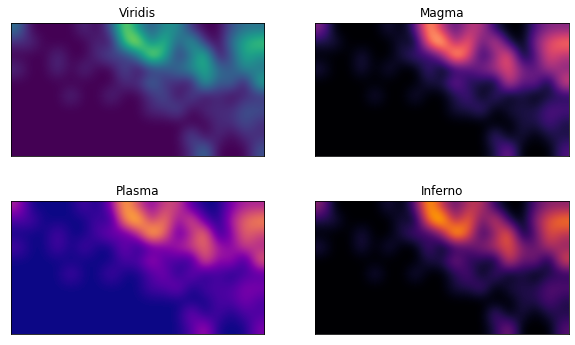

In [9]:
fig = plt.figure(figsize=[10,6])

ax = plt.subplot(221)
aa = ax.imshow([psth_dict[i] for i in sorted(psth_dict.keys())],
               origin='lower',
               cmap='viridis',
               interpolation='bicubic') 
ax.set_title("Viridis")
plt.yticks([]); plt.xticks([])

ax = plt.subplot(222)
aa = ax.imshow([psth_dict[i] for i in sorted(psth_dict.keys())],
               origin='lower',
               cmap='magma',
               interpolation='bicubic') 
ax.set_title("Magma")
plt.yticks([]); plt.xticks([])

ax = plt.subplot(223);
aa = ax.imshow([psth_dict[i] for i in sorted(psth_dict.keys())],
               origin='lower',
               cmap='plasma',
               interpolation='bicubic') 
ax.set_title("Plasma")
plt.yticks([]); plt.xticks([])

ax = plt.subplot(224)
aa = ax.imshow([psth_dict[i] for i in sorted(psth_dict.keys())],
               origin='lower',
               cmap='inferno',
               interpolation='bicubic') 
ax.set_title("Inferno")
plt.yticks([]); plt.xticks([])

plt.show()

Compare these plots to  ones above that use non-viridis colourmaps (including the ones above, and some more examples below) and ask yourself how your perception and interpretation of the plots changes between them. 

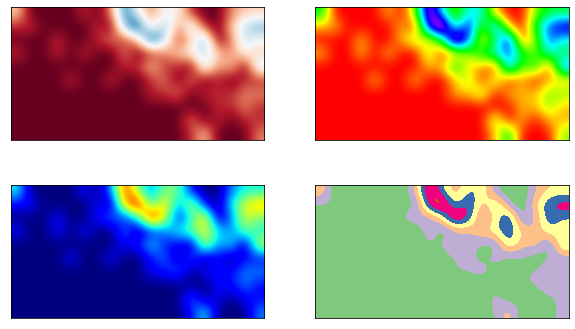

In [10]:
fig = plt.figure(figsize=[10,6])
ax = plt.subplot(221);aa = ax.imshow([psth_dict[i] for i in sorted(psth_dict.keys())],
                                     cmap='RdBu',
                                     interpolation='bicubic',origin='lower') ; plt.yticks([]); plt.xticks([])
ax = plt.subplot(222);aa = ax.imshow([psth_dict[i] for i in sorted(psth_dict.keys())],
                                     cmap='hsv', 
                                     interpolation='bicubic',origin='lower') ;plt.yticks([]); plt.xticks([])
ax = plt.subplot(223);aa = ax.imshow([psth_dict[i] for i in sorted(psth_dict.keys())],
                                     cmap='jet', 
                                     interpolation='bicubic',origin='lower') ;plt.yticks([]); plt.xticks([])
ax = plt.subplot(224);aa = ax.imshow([psth_dict[i] for i in sorted(psth_dict.keys())],
                                     cmap='Accent', 
                                     interpolation='bicubic',origin='lower');plt.yticks([]); plt.xticks([])
plt.show()